#Table of Contents
* [Homework 0](#Homework-0)
    * [Import](#Import)
	* [Functions Definitions](#Functions Definitions)
		* [1. generate_tp_and_fp_vcfs](#1.-generate_tp_and_fp_vcfs)
		* [2. qual](#2.-qual)
		* [3. count_freq](#3.-count_freq)
		* [4. count_homopolymers](#4.-count_homopolymers)
        * [5. feature_matrix](#5.-feature_matrix)
        * [6. count_homopolymers_with_indel](#6._count_homopolymers_with_indel)
        * [7. indel_positions_in_reads](#7._indel_positions_in_reads)
        * [8. try_understand_bam](#8._try_understand_bam)
        * [9. indel_proofs](9._indel_proofs)
	* [Features Analysis](#Features Analysis)
		* [1. Quality](#1.-Quality)
		* [2. Count homopolymers](#2.-Count homopolymers)
		* [3. Count nucleotydes](#3.-Count nucleotydes)
        * [4. PCA from tp and fp](#4._PCA_from_tp_and_fp)
        * [5. Count homopolymers with indels](#5.-Count-homopolymers-with-indels)
        * [6. Analysis of location of indels in reads](#6._Analysis_of_location_of_indels_in_reads)
        * [7. Analysis of reads-proofs of indels](#7._Analysis_of_reads-proofs_of_indels)

### Import

In [1]:
import plotly
import pysam 
import math
import vcf as pyvcf
from pyfasta import Fasta
from classes.suffix_tree import SuffixTree
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn import datasets
from scipy import stats, integrate
import seaborn as sns

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


Инициализация путей и словаря для доступа к записям референса

In [2]:
%matplotlib inline
our_vcf = '/home/alexgri/indels/gcat_set_059-ensemble.vcf'
our_short_vcf = '/home/alexgri/indels/gcat_set_059-ensemble_head.vcf'
example_vcf = '/home/alexgri/indels/short.vcf'
true_vcf = '/home/alexgri/indels/NA12878.vcf'
tp_vcf = '/home/alexgri/indels/gcat_set_059-ensemble_tp.vcf'
fp_vcf = '/home/alexgri/indels/gcat_set_059-ensemble_fp.vcf'
reference = '/home/alexgri/indels/human_g1k_v37.fasta'
our_bam = '/home/alexgri/indels/GoldenStandard_OurAlgorithms/gcat_set_059-ready.bam'
chr_dict = {'1':'1 dna:chromosome chromosome:GRCh37:1:1:249250621:1',
            '2':'2 dna:chromosome chromosome:GRCh37:2:1:243199373:1',
            '3':'3 dna:chromosome chromosome:GRCh37:3:1:198022430:1',
            '4':'4 dna:chromosome chromosome:GRCh37:4:1:191154276:1',
            '5':'5 dna:chromosome chromosome:GRCh37:5:1:180915260:1',
            '6':'6 dna:chromosome chromosome:GRCh37:6:1:171115067:1',
            '7':'7 dna:chromosome chromosome:GRCh37:7:1:159138663:1',
            '8':'8 dna:chromosome chromosome:GRCh37:8:1:146364022:1',
            '9':'9 dna:chromosome chromosome:GRCh37:9:1:141213431:1',
            '10':'10 dna:chromosome chromosome:GRCh37:10:1:135534747:1',
            '11':'11 dna:chromosome chromosome:GRCh37:11:1:135006516:1',
            '12':'12 dna:chromosome chromosome:GRCh37:12:1:133851895:1',
            '13':'13 dna:chromosome chromosome:GRCh37:13:1:115169878:1',
            '14':'14 dna:chromosome chromosome:GRCh37:14:1:107349540:1',
            '15':'15 dna:chromosome chromosome:GRCh37:15:1:102531392:1',
            '16':'16 dna:chromosome chromosome:GRCh37:16:1:90354753:1',
            '17':'17 dna:chromosome chromosome:GRCh37:17:1:81195210:1',
            '18':'18 dna:chromosome chromosome:GRCh37:18:1:78077248:1',
            '19':'19 dna:chromosome chromosome:GRCh37:19:1:59128983:1',
            '20':'20 dna:chromosome chromosome:GRCh37:20:1:63025520:1',
            '21':'21 dna:chromosome chromosome:GRCh37:21:1:48129895:1',
            '22':'22 dna:chromosome chromosome:GRCh37:22:1:51304566:1',
            'X':'X dna:chromosome chromosome:GRCh37:X:1:155270560:1',
            'Y':'Y dna:chromosome chromosome:GRCh37:Y:2649521:59034049:1'}
chr_dict2 = {'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'10':10,
            '11':11,'12':12,'13':13,'14':14,'15':15,'16':16,'17':17,'18':18,
            '19':19,'20':20,'21':21,'22':22,'X':23,'Y':24}

### 1. generate_tp_and_fp_vcfs
Функция для генерации vcf с true positive инделами и vcf с false positive инделами

In [10]:
def generate_tp_and_fp_vcfs(path_to_vcf,path_to_valid_vcf,path_to_tp_vcf=None,path_to_fp_vcf=None):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = float(size[0])
    size_valid = !cat $path_to_valid_vcf | grep -v "#" |wc -l
    size_valid = float(size_valid[0])
    not_valid_vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    valid_vcf = pyvcf.Reader(open(path_to_valid_vcf, 'r'))
    tp_vcf_writer = pyvcf.Writer(open(path_to_tp_vcf, 'w'), not_valid_vcf)
    fp_vcf_writer = pyvcf.Writer(open(path_to_fp_vcf, 'w'), not_valid_vcf)
    k=0
    n=0
    record = not_valid_vcf.next()
    k+=1
    while (not record.is_indel):
        if (k<size):
            record = not_valid_vcf.next()
        else:
            return 0
        k+=1
    valid_record = valid_vcf.next()
    n+=1
    while (True):
        if (chr_dict2[record.CHROM]>chr_dict2[valid_record.CHROM[3:]]):
            if (n<size_valid):
                valid_record = valid_vcf.next()
            else:
                tp_vcf_writer.close()
                fp_vcf_writer.close()
                return 0
            n+=1
        elif (chr_dict2[record.CHROM]==chr_dict2[valid_record.CHROM[3:]]):
            if (record.POS>valid_record.POS): 
                if (n<size_valid):
                    valid_record = valid_vcf.next()
                else:
                    tp_vcf_writer.close()
                    fp_vcf_writer.close()
                    return 0
                n+=1
            elif (record.POS==valid_record.POS):
                if (record.ALT[0]==valid_record.ALT[0]):
                    tp_vcf_writer.write_record(record)
                    if (k<size):
                        record = not_valid_vcf.next()
                    else:
                        tp_vcf_writer.close()
                        fp_vcf_writer.close()
                        return 0
                    k+=1
                    while (not record.is_indel):
                        if (k<size):
                            record = not_valid_vcf.next()
                        else:
                            tp_vcf_writer.close()
                            fp_vcf_writer.close()
                            return 0
                        k+=1
                else:
                    fp_vcf_writer.write_record(record)
                    if (k<size):
                        record = not_valid_vcf.next()
                    else:
                        tp_vcf_writer.close()
                        fp_vcf_writer.close()
                        return 0
                    k+=1
                    while (not record.is_indel):
                        if (k<size):
                            record = not_valid_vcf.next()
                        else:
                            tp_vcf_writer.close()
                            fp_vcf_writer.close()
                            return 0
                        k+=1
            elif (record.POS<valid_record.POS):
                fp_vcf_writer.write_record(record)
                if (k<size):
                    record = not_valid_vcf.next()
                else:
                    tp_vcf_writer.close()
                    fp_vcf_writer.close()
                    return 0
                k+=1
                while (not record.is_indel):
                    if (k<size):
                        record = not_valid_vcf.next()
                    else:
                        tp_vcf_writer.close()
                        fp_vcf_writer.close()
                        return 0
                    k+=1
        else:
            fp_vcf_writer.write_record(record)
            if (k<size):
                record = not_valid_vcf.next()
            else:
                tp_vcf_writer.close()
                fp_vcf_writer.close()
                return 0
            k+=1
            while (not record.is_indel):
                if (k<size):
                    record = not_valid_vcf.next()
                else:
                    tp_vcf_writer.close()
                    fp_vcf_writer.close()
                    return 0
                k+=1

In [11]:
generate_tp_and_fp_vcfs(our_vcf,true_vcf,tp_vcf,fp_vcf)

0

### 2. qual
Функция для генерации качества по всем инделам

In [13]:
def qual(path_to_vcf):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = size[0]
    vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    arr = np.ndarray(0)
    i=0
    n=0
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if record.is_indel: 
                arr = np.append(arr, record.QUAL)
        #if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
        n+=1
    return arr

### 3. count_freq
Функция для подсчета частот нулеотидов слева и справа от индела

In [14]:
def count_freq(path_to_reference,path_to_vcf,N):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = size[0]
    vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    ref = Fasta(path_to_reference)
    dfl = pd.DataFrame(columns=range(1,N+1),index = ['A','T','G','C','all']).fillna(float(0))
    dfr = pd.DataFrame(columns=range(1,N+1),index = ['A','T','G','C','all']).fillna(float(0))
    n=0
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if record.is_indel: 
                chrom = chr_dict[record.CHROM]
                for i in range(1,N+1):
                    for nuc in ['A','T','G','C']:   
                        dfr.loc[nuc,i] += ref[chrom][record.POS+len(record.REF)-1:record.POS-1+len(record.REF)+i].count(nuc)
                        dfl.loc[nuc,i] += ref[chrom][record.POS-1-i:record.POS-1].count(nuc)
                    dfr.loc['all',i] += i
                    dfl.loc['all',i] += i
        #if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
        n+=1
    for i in range(1,N+1):
        for nuc in ['A','T','G','C']: 
            dfl.loc[nuc,i] /= dfl.loc['all',i]
            dfr.loc[nuc,i] /= dfr.loc['all',i]
    dfl = dfl.transpose().drop('all',1)
    dfl['A+T']=dfl['A']+dfl['T']
    dfl['G+C']=dfl['G']+dfl['C']
    dfr = dfr.transpose().drop('all',1)
    dfr['A+T']=dfr['A']+dfr['T']
    dfr['G+C']=dfr['G']+dfr['C']  
    return dfl,dfr



### 4. count_homopolymers
Функция для подсчета количества инделов конкретной длины с гомополимером конкретной длины слева или справа

In [133]:
def count_homopolymers(path_to_reference,path_to_vcf):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = size[0]
    vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    ref = Fasta(path_to_reference)
    dfl = pd.DataFrame(columns=range(100),index=range(100)).fillna(0)
    dfr = pd.DataFrame(columns=range(100),index=range(100)).fillna(0)
    n=0
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if record.is_indel: 
                chrom = chr_dict[record.CHROM]
                i = 1
                char = ref[chrom][record.POS-2]
                while (ref[chrom][record.POS-2-i]==char):
                    i+=1
                dfl.loc[abs(len(record.REF)-len(alt)),i] += 1 
                i = 1
                char = ref[chrom][record.POS+len(record.REF)-1]
                while (ref[chrom][record.POS+len(record.REF)-1+i]==char):
                    i+=1
                dfr.loc[abs(len(record.REF)-len(alt)),i] += 1
        #if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
        n+=1
    return dfl,dfr

2. строчка while (ref[chrom][record.POS+len(record.REF)-1+i:record.POS+len(record.REF)+i]==ref[chrom][record.POS-1+len(record.REF):record.POS+len(record.REF)]): - нечитаемая. Разве len(record.REF) - это что? В случае делеции - длина делеции (формальная), а в случае инсерции?


df.loc[abs(len(record.REF)-len(record.ALT[0])),i] += 1 - не осознал. Разве len(record.ALT[0]) не тождественно равно 1? 

оставшиеся штуки надо обсудить

### 5. feature_matrix
Последовательность фичей:<br>
0.log indel quality<br>
1.left hompolymer length<br>
2.right hompolymer length<br>
3.left 5 A+T <br>
4.left 5 G+C<br>
5.right 5 A+T<br>
6.right 5 G+C<br>
7.indel A+T<br>
8.indel G+C<br>
9.max homopolymer length in indel<br>
10.indel length <br>
11.(homopolymer is on the end)&(homopolymer nuc matches next nuc) {0,1}<br>

In [5]:
def string_to_homopolymers(s):
    homo = []
    i=0
    number = 0
    cur_nuc = s[0]
    while True:
        while (s[i]==cur_nuc):
            number+=1
            i+=1
            if (i==len(s)):
                homo.append((cur_nuc,number))
                return homo
        homo.append((cur_nuc,number))
        number = 0
        cur_nuc = s[i]
def feature_matrix(path_to_reference,path_to_true_vcf,path_to_false_vcf):
    size_true = !cat $path_to_true_vcf | grep -v "#" |wc -l
    size_false = !cat $path_to_false_vcf | grep -v "#" |wc -l
    size = int(size_true[0]) + int(size_false[0])
    n=0
    true_vcf = pyvcf.Reader(open(path_to_true_vcf, 'r'))
    false_vcf = pyvcf.Reader(open(path_to_false_vcf, 'r'))
    ref = Fasta(path_to_reference)
    X = pd.DataFrame(index=range(12))
    y = np.ndarray(0)
    for record in true_vcf:
        for alt in [record.ALT[0]]:
            if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
            n+=1
            alt = str(alt)
            #print record
            #print record.QUAL
            temp = np.ndarray(12)
            chrom = chr_dict[record.CHROM]
            #print ref[chrom][record.POS-6:record.POS+len(record.REF)+4]
            temp[0] = math.log(record.QUAL)
            i = 1
            char = ref[chrom][record.POS-2]
            while (ref[chrom][record.POS-2-i]==char):
                i+=1
            temp[1] = i
            i = 1
            char = ref[chrom][record.POS+len(record.REF)-1]
            while (ref[chrom][record.POS+len(record.REF)-1+i]==char):
                i+=1
            temp[2] = i
            string = ref[chrom][record.POS-6:record.POS-1]
            temp[3] = (string.count('A')+string.count('T'))/float(5)
            temp[4] = (string.count('G')+string.count('C'))/float(5)
            string = ref[chrom][record.POS+len(record.REF)-1:record.POS+len(record.REF)+4]
            temp[5] = (string.count('A')+string.count('T'))/float(5)
            temp[6] = (string.count('G')+string.count('C'))/float(5)
            temp[7] = (alt.count('A')+alt.count('T'))/len(alt)
            temp[8] = (alt.count('G')+alt.count('C'))/len(alt)
            homo = string_to_homopolymers(alt)
            temp[9] = max([a for b,a in homo])
            temp[10] = abs(len(alt)- len(record.REF))
            temp[11] = (homo[0][1]==temp[9] and homo[0][0]==ref[chrom][record.POS-2]) or (homo[len(homo)-1][1]==temp[9] and homo[len(homo)-1][0]==ref[chrom][record.POS+len(record.REF)-1])
            X[X.shape[1]] = temp
            y = np.append(y,1)
            #print temp
    for record in false_vcf:
        for alt in [record.ALT[0]]:
            if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
            n+=1
            alt = str(alt)
            #print record
            #print record.QUAL
            temp = np.ndarray(12)
            chrom = chr_dict[record.CHROM]
            #print ref[chrom][record.POS-6:record.POS+len(record.REF)+4]
            temp[0] = math.log(record.QUAL)
            i = 1
            char = ref[chrom][record.POS-2]
            while (ref[chrom][record.POS-2-i]==char):
                i+=1
            temp[1] = i
            i = 1
            char = ref[chrom][record.POS+len(record.REF)-1]
            while (ref[chrom][record.POS+len(record.REF)-1+i]==char):
                i+=1
            temp[2] = i
            string = ref[chrom][record.POS-6:record.POS-1]
            temp[3] = (string.count('A')+string.count('T'))/float(5)
            temp[4] = (string.count('G')+string.count('C'))/float(5)
            string = ref[chrom][record.POS+len(record.REF)-1:record.POS+len(record.REF)+4]
            temp[5] = (string.count('A')+string.count('T'))/float(5)
            temp[6] = (string.count('G')+string.count('C'))/float(5)
            temp[7] = (alt.count('A')+alt.count('T'))/len(alt)
            temp[8] = (alt.count('G')+alt.count('C'))/len(alt)
            homo = string_to_homopolymers(alt)
            temp[9] = max([a for b,a in homo])
            temp[10] = abs(len(alt)- len(record.REF))
            temp[11] = (homo[0][1]==temp[9] and homo[0][0]==ref[chrom][record.POS-2]) or (homo[len(homo)-1][1]==temp[9] and homo[len(homo)-1][0]==ref[chrom][record.POS+len(record.REF)-1])
            X[X.shape[1]] = temp
            y = np.append(y,0)
            #print temp
    return (X,y)

### 6. count_homopolymers_with_indel
Находим максимальный гомополимер в инделе и в случае возможности продления его влево и/или вправо продлеваем его влево и/или вправо

In [25]:
def count_homopolymers_with_indels(path_to_reference,path_to_vcf):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = size[0]
    vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    ref = Fasta(path_to_reference)
    df = pd.DataFrame(columns=range(100),index=range(100)).fillna(0)
    n=0
    k=0
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if record.is_indel:
                alt = str(alt)
                k+=1
                chrom = chr_dict[record.CHROM]
                #print record
                #print ref[chrom][record.POS-10:record.POS-1]+'\t'+alt+'\t'+ref[chrom][record.POS+len(record.REF)-1:record.POS+len(record.REF)+8]
                homo = string_to_homopolymers(str(alt))
                #print homo
                homo_max = max([y for x,y in homo])
                max_in_homo =  [a for a in range(len(homo)) if homo[a][1]==homo_max]
                left = 0 in max_in_homo
                right = (len(homo)-1) in max_in_homo
                if (len(homo)==1):
                    i=0
                    char = homo[0][0]
                    while (ref[chrom][record.POS-2-i]==char):
                        i += 1
                    j=0
                    while (ref[chrom][record.POS+len(record.REF)-1+j]==char):
                        j += 1
                    df.loc[abs(len(record.REF)-len(alt)),i+j+homo_max] += 1
                    #print homo_max+i+j
                elif (not left and not right):
                    df.loc[abs(len(record.REF)-len(alt)),homo_max] += 1
                    #print homo_max
                elif (left and not right):
                    i=0
                    char = homo[0][0]
                    while (ref[chrom][record.POS-2-i]==char):
                        i += 1
                    df.loc[abs(len(record.REF)-len(alt)),i+homo_max] += 1
                    #print homo_max+i
                elif (not left and right):
                    i=0
                    char = homo[len(homo)-1][0]
                    while (ref[chrom][record.POS+len(record.REF)-1+i]==char):
                        i += 1
                    df.loc[abs(len(record.REF)-len(alt)),i+homo_max] += 1
                    #print homo_max+i
                else:
                    i=0
                    char = homo[0][0]
                    while (ref[chrom][record.POS-2-i]==char):
                        i += 1
                    char = homo[len(homo)-1][0]
                    j=0
                    while (ref[chrom][record.POS+len(record.REF)-1+j]==char):
                        j += 1
                    df.loc[abs(len(record.REF)-len(alt)),max(i,j)+homo_max] += 1
                    #print homo_max+max(i,j)
        if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
        n+=1
    return df

In [81]:
def rec_count_homopolymers(path_to_reference,chrom,letter,pos,direction):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = size[0]
    ref = Fasta(path_to_reference)
    print ref[chrom][pos-5:pos+5]
    if (ref[chrom][pos-1]==letter): return rec_count_homopolymers(path_to_reference,chrom,letter,pos+direction,direction)
    return pos
print 865437-rec_count_homopolymers(reference,chr_dict['1'],'C',865437,-1)
print rec_count_homopolymers(reference,chr_dict['1'],'G',865439,+1)-865439

ACCCCCGGGA
GACCCCCGGG
AGACCCCCGG
CAGACCCCCG
GCAGACCCCC
4
CCCCGGGAGA
CCCGGGAGAT
CCGGGAGATG
CGGGAGATGG
3


### 7. indel_positions_in_reads
Для каждого индела считаем (позиция в риде, длина рида) для каждого рида. Доверительный интервал 

In [101]:
def indel_positions_in_reads(path_to_reference,path_to_bam,path_to_vcf):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = size[0]
    samfile = pysam.AlignmentFile(path_to_bam, "rb")
    vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    ref = Fasta(path_to_reference)
    full_list = []
    n=0
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if record.is_indel:
                alt=str(alt)
                chrom=chr_dict[record.CHROM]
                iter = samfile.fetch(record.CHROM, record.POS, record.POS + 1)
                array = []
                for read in iter:
                    if ((record.POS-1) in read.positions):
                        array.append([read.positions.index(record.POS-1)+1,len(read.positions)])
                    else: continue
                full_list.append(array)
        if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
        n+=1
    samfile.close()
    return full_list

### 8. try_understand_bam
Функция для того, чтобы разобраться, что из себя представляет bam файл и как с ним правильно работать.

In [20]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
def try_understand_bam(path_to_bam,path_to_ref,chrom,pos):
    samfile = pysam.AlignmentFile(path_to_bam, "rb")
    ref = Fasta(path_to_ref)
    chrom = chr_dict[chrom]
    for position in range(pos,pos+1):
        iter = samfile.fetch("1", position, position + 1)
        for x in iter:
            df = pd.DataFrame(index=np.arange(sum([b for a,b in x.cigar])))
            array = np.ndarray(0)
            for cig in x.cigar:
                array = np.append(array,(np.zeros(cig[1])+ cig[0]))
            df['CIGAR'] = array.astype(int)
            i = 0
            array = []
            for a in df['CIGAR']:
                if (a in [0,1,4,7]):
                    array.append(x.seq[i])
                    i+=1
                else:array.append(None)
            df['SEQ'] = array
            i = 0
            array = []
            for a in range(len(df['CIGAR'])):
                if (df.CIGAR[a]!=0):
                    array.append(None)
                else:
                    array.append(x.positions[i])
                    i+=1
            df['POS'] = array
            array = []
            for a in range(len(df['CIGAR'])):
                if (df.POS[a]==None or np.isnan(df.POS[a])):
                    array.append(None)
                else:
                    array.append(ref[chrom][int(df.POS[a])])
            df['REF'] = array
            print_full(df)
            print x.get_blocks()
            print x.get_overlap(pos-1 ,pos)
    samfile.close()
try_understand_bam(our_bam,reference,'1',989417)

     CIGAR   SEQ     POS   REF
0        4     G     NaN  None
1        4     A     NaN  None
2        4     C     NaN  None
3        0     G  989206     G
4        0     T  989207     T
5        0     G  989208     G
6        0     G  989209     G
7        0     C  989210     C
8        0     A  989211     A
9        0     A  989212     A
10       0     G  989213     G
11       0     G  989214     G
12       0     C  989215     C
13       0     C  989216     C
14       0     A  989217     A
15       0     C  989218     C
16       0     G  989219     G
17       0     G  989220     G
18       0     A  989221     A
19       0     G  989222     G
20       0     C  989223     C
21       0     G  989224     G
22       0     G  989225     G
23       0     G  989226     G
24       0     C  989227     C
25       0     A  989228     A
26       0     G  989229     G
27       0     A  989230     A
28       0     C  989231     C
29       0     T  989232     T
30       0     A  989233     A
31      

### 9. indel_proofs
Для каждого индела считаем долю доказывающих его ридов относительно всех покрывающих.

In [29]:
def indel_proofs(path_to_reference,path_to_bam,path_to_vcf):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = size[0]
    samfile = pysam.AlignmentFile(path_to_bam, "rb")
    vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    ref = Fasta(path_to_reference)
    list = []
    n=0
    proofs = 0
    reads = 0
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if record.is_indel:
                alt=str(alt)
                chrom=chr_dict[record.CHROM]
                iter = samfile.fetch(record.CHROM, record.POS, record.POS + 1)
                array = []
                length = len(alt)-len(record.REF) # длина индела
                for read in iter:
                    reads+=1
                    pos = None
                    ref_seq = [y for t in read.get_blocks() for y in t]
                    if ((record.POS-1) in read.positions): # проверяем присутствие буквы перед инделом
                        pos = read.positions.index(record.POS-1)
                    if (pos is None or len(read.positions)==pos+1):
                        # не подтверждает из-за отсутсвия буквы перед инделом или из-за непокрытия индела
                        continue
                    elif (length<0 and record.POS in ref_seq and (ref_seq[ref_seq.index(record.POS)+1]-record.POS)+length==0):
                        # случай делеции, проверяем подтверждение рида 
                        # проверяем присутствие и длину разрыва в выравнивании на референс в позиции делеции
                        proofs+=1
                    elif (length>0 and ref_seq.count(record.POS)==2 and read.get_overlap(record.POS-1,record.POS)==length):# случай делеции, проверяем подтверждение рида 
                        # случай инзерции, проверяем подтверждение рида 
                        # проверяем присутствие вставки в выравнивании на референс в позиции инзерции
                        # проверяем равенство длины вставки в последовательности рида длине инзерции
                        proofs+=1
                    else: continue
                list.append(float(proofs)/reads)
        if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
        n+=1
    samfile.close()
    return list

### Feature Analysis
### 1. Quality

In [131]:
quals = qual(our_vcf)
quals_tp = qual(tp_vcf)
quals_fp = qual(fp_vcf)

[ 2264.73   880.73   103.47 ...,   238.97   196.26   133.97]


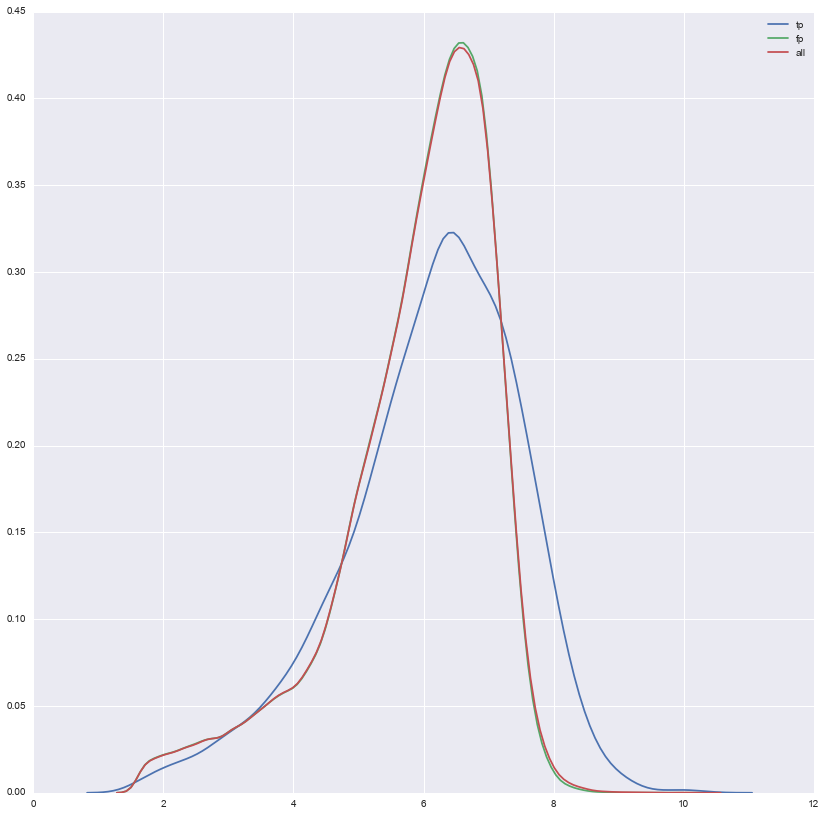

In [206]:
plt.figure(figsize=(14,14))
sns.set(color_codes=True)
sns.distplot(np.log(quals_tp),hist=False,label='tp')
sns.distplot(np.log(quals_fp),hist=False,label='fp')
sns.distplot(np.log(quals),hist=False,label='all')

### 2. Count homopolymers

In [133]:
df_left, df_right = count_homopolymers(reference,our_vcf)
df_left_tp, df_right_tp = count_homopolymers(reference,tp_vcf)
df_left_fp, df_right_fp = count_homopolymers(reference,fp_vcf)

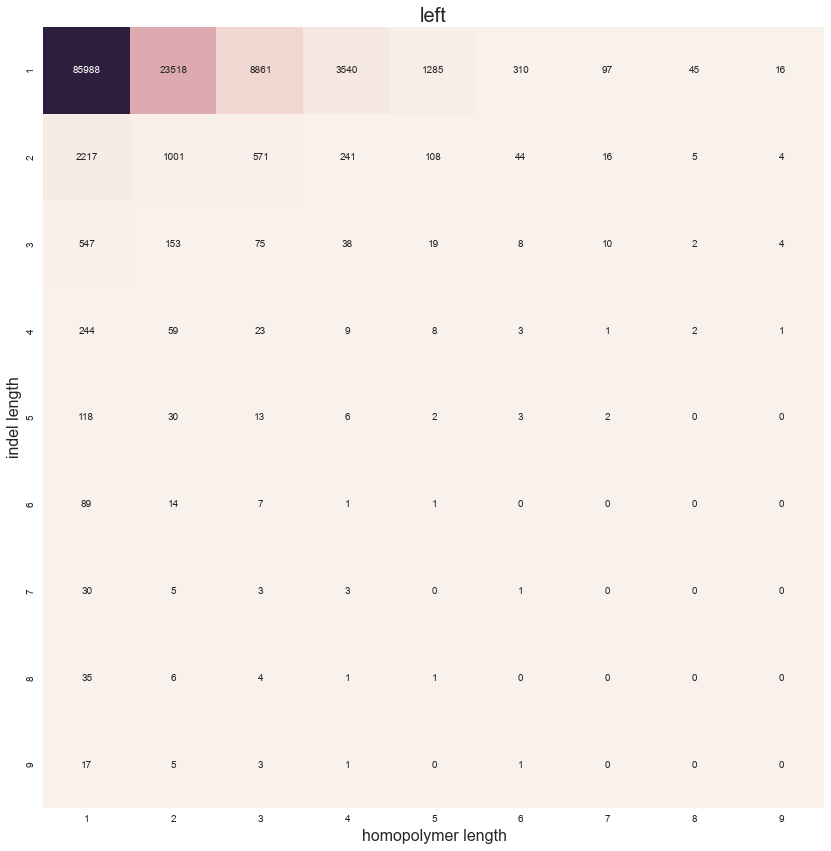

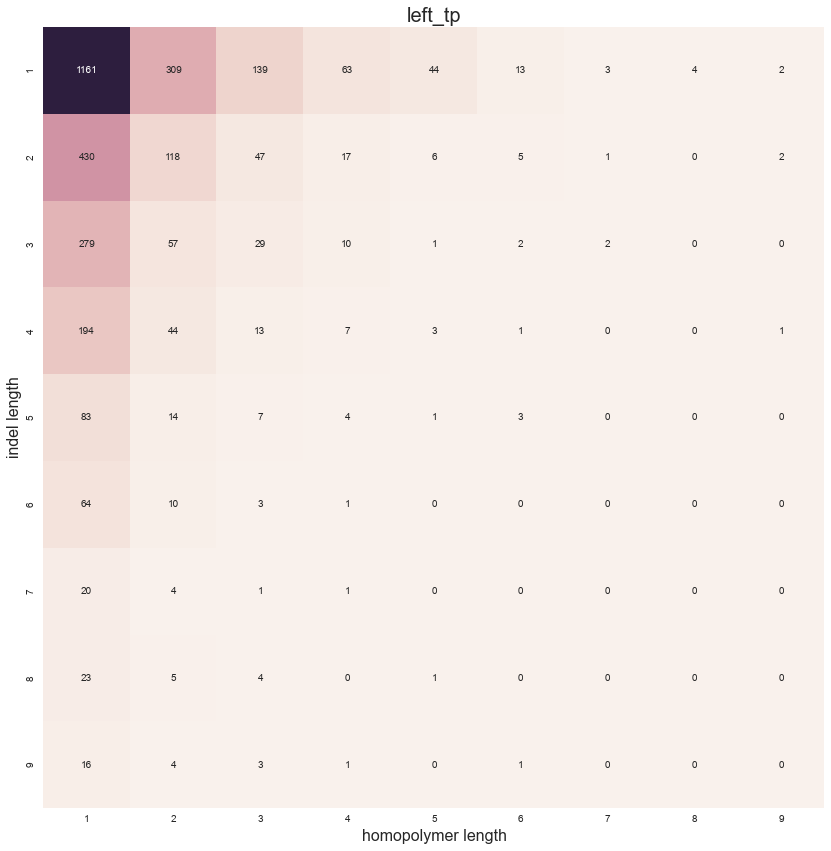

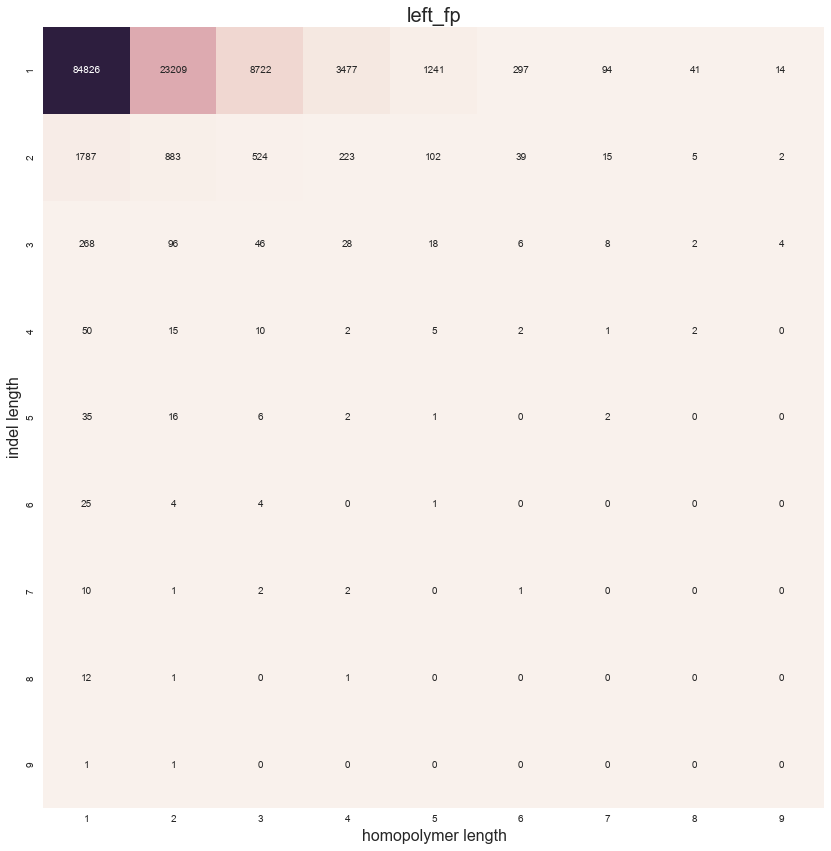

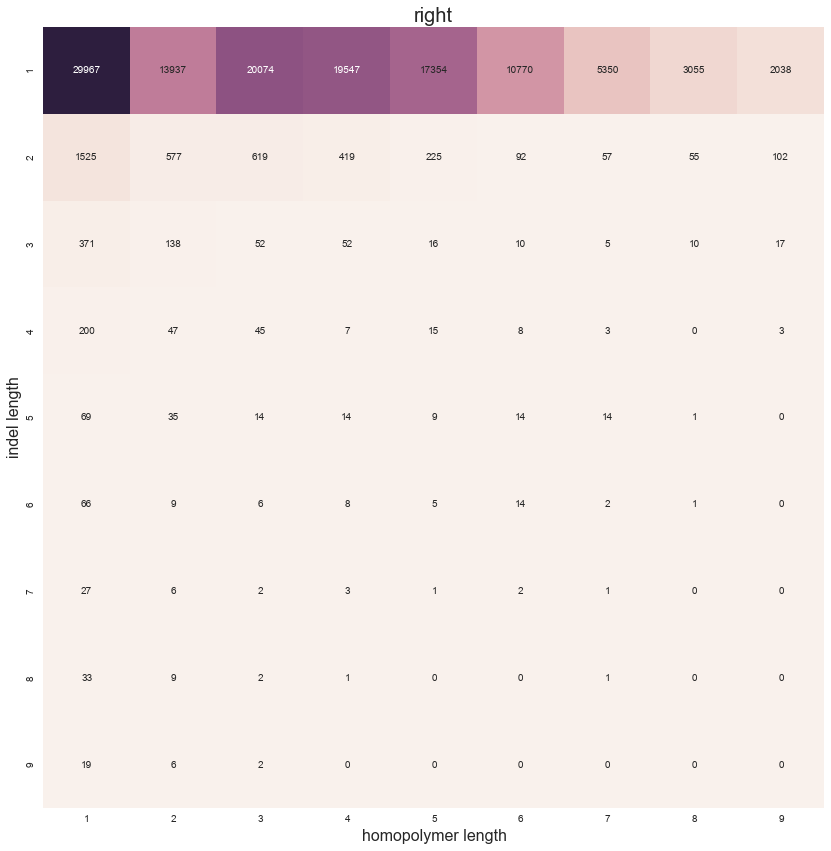

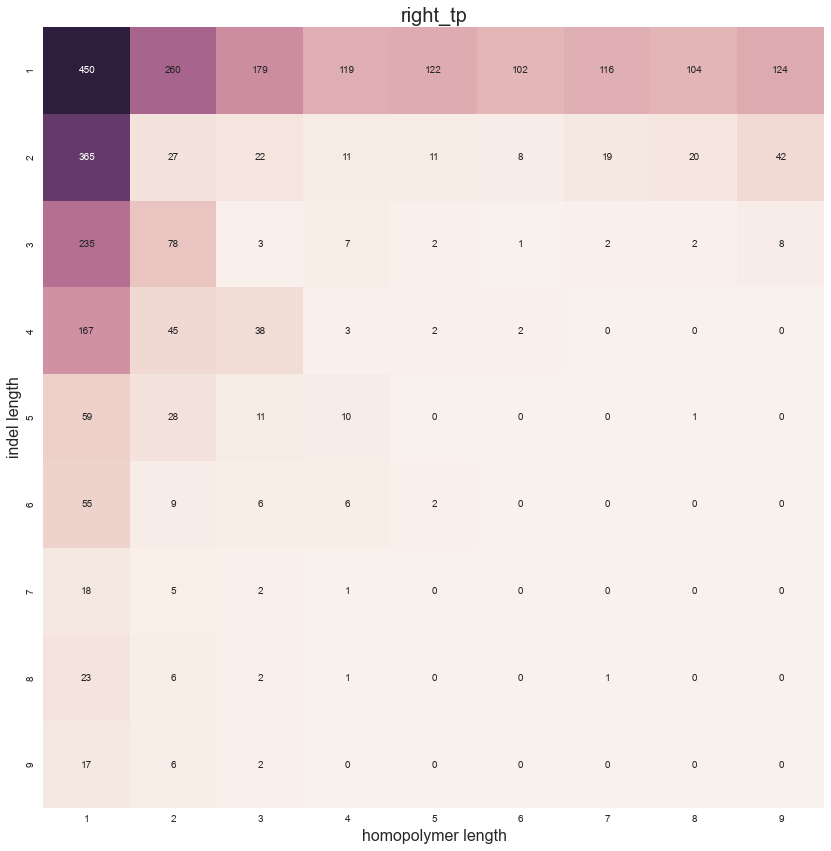

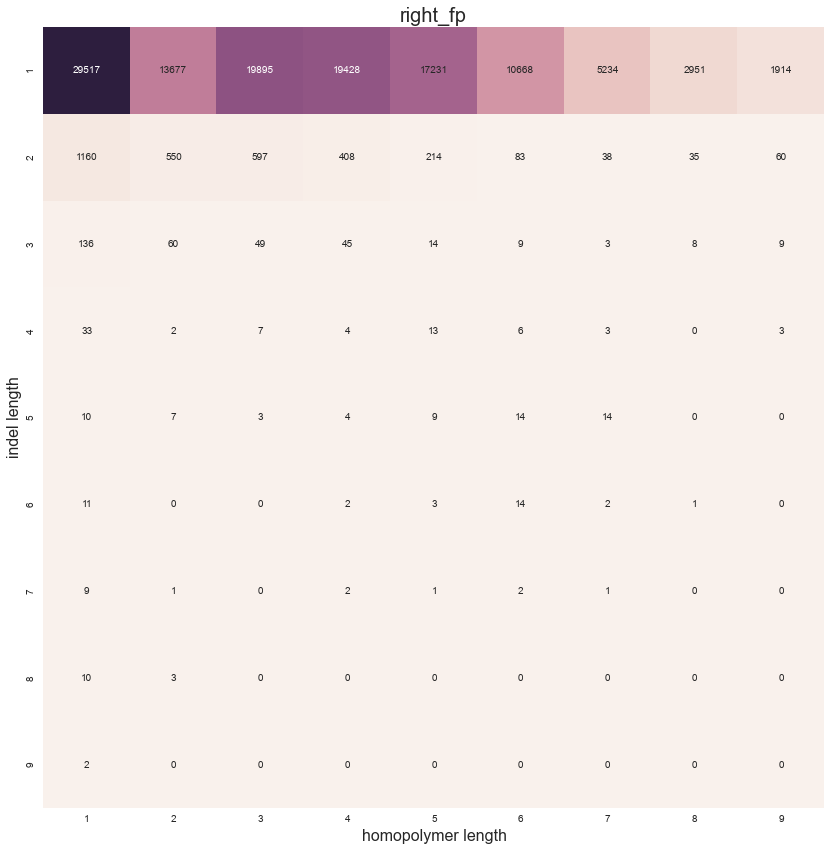

In [189]:
for df,name in [[df_left,'left'],[df_left_tp,'left_tp'],[df_left_fp,'left_fp'],[df_right,'right'],[df_right_tp,'right_tp'],[df_right_fp,'right_fp']]:
    fig = plt.figure(figsize=(14, 14), dpi=500)
    hmap = sns.heatmap(df.as_matrix()[1:10,1:10],cbar = False,annot = True, fmt = 'd',xticklabels = np.arange(9)+1,yticklabels = np.arange(9)+1)
    plt.xlabel('homopolymer length',fontsize=16)
    plt.ylabel('indel length',fontsize=16)
    plt.title(name,fontsize = 20)

Нормализованные распределения длин гомополимеров для инделов длины 1

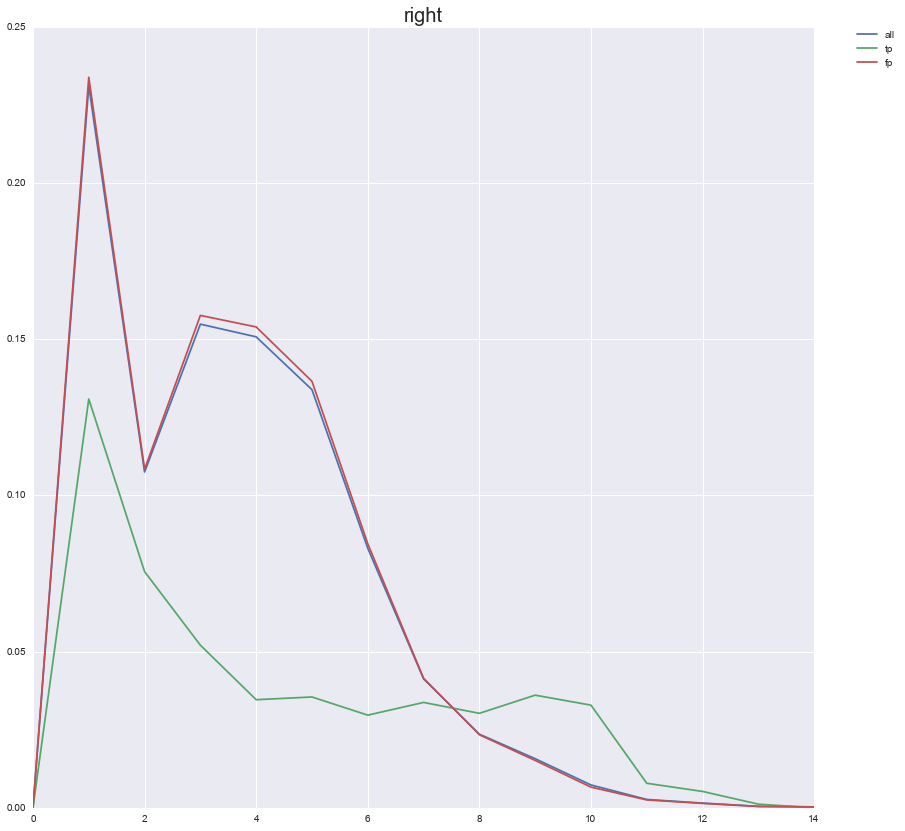

In [209]:
plt.figure(figsize=(14,14))
(df_right/df_right.sum().sum()).T[1][:15].plot(label=u"all")
(df_right_tp/df_right_tp.sum().sum()).T[1][:15].plot(label=u"tp")
(df_right_fp/df_right_fp.sum().sum()).T[1][:15].plot(label=u"fp")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('right',fontsize=20)
plt.show()

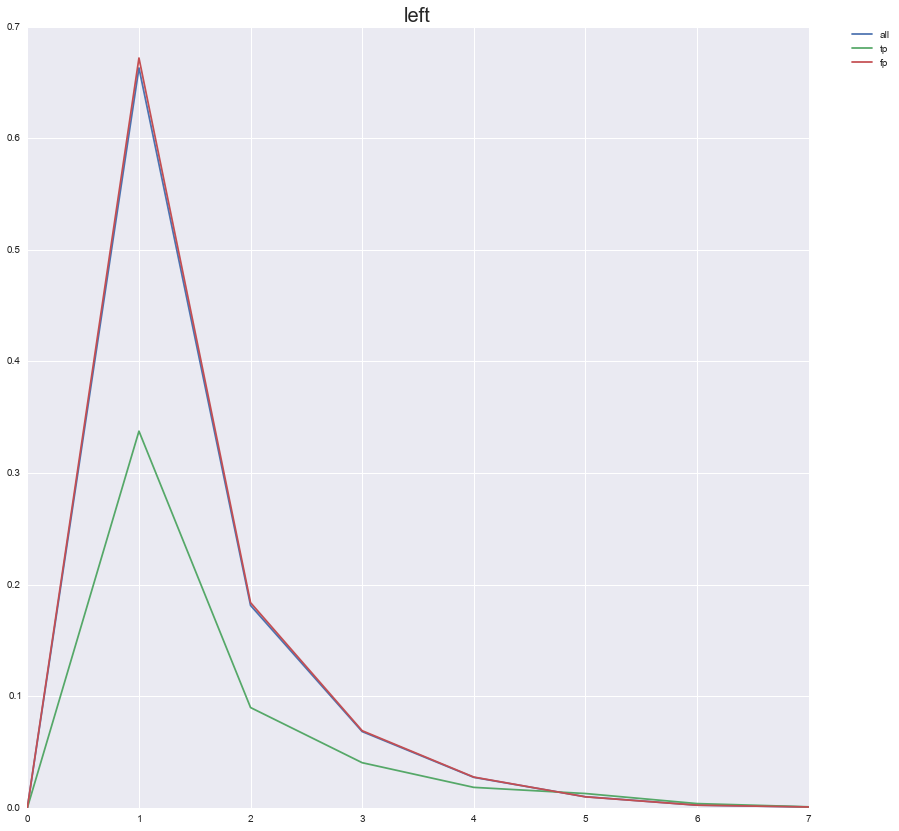

In [192]:
plt.figure(figsize=(14,14))
(df_left/df_left.sum().sum()).T[1][:8].plot(label=u"all")
(df_left_tp/df_left_tp.sum().sum()).T[1][:8].plot(label=u"tp")
(df_left_fp/df_left_fp.sum().sum()).T[1][:8].plot(label=u"fp")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('left',fontsize=20)
plt.show()

### 3. Count nucleotydes

In [134]:
freq_left, freq_right = count_freq(reference,our_vcf,15)
freq_left_tp, freq_right_tp = count_freq(reference,tp_vcf,15)
freq_left_fp, freq_right_fp = count_freq(reference,fp_vcf,15)

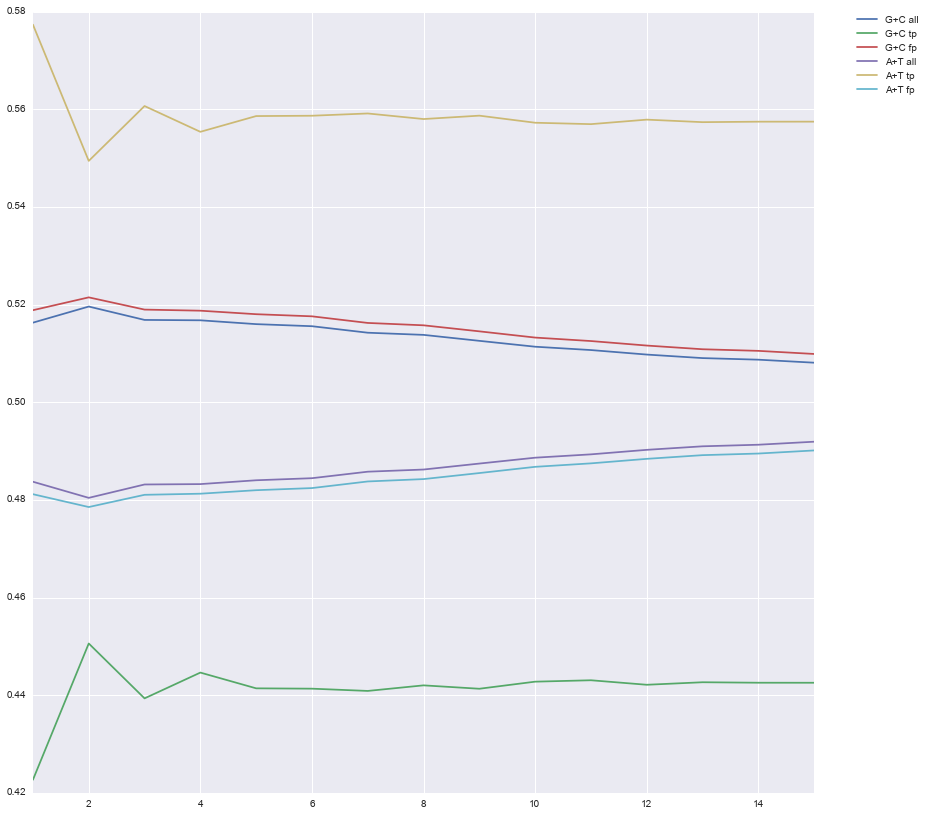

In [115]:
plt.figure(figsize=(14,14))
freq_left['G+C'].plot(label='G+C all')
freq_left_tp['G+C'].plot(label='G+C tp')
freq_left_fp['G+C'].plot(label='G+C fp')
freq_left['A+T'].plot(label='A+T all')
freq_left_tp['A+T'].plot(label='A+T tp')
freq_left_fp['A+T'].plot(label='A+T fp')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

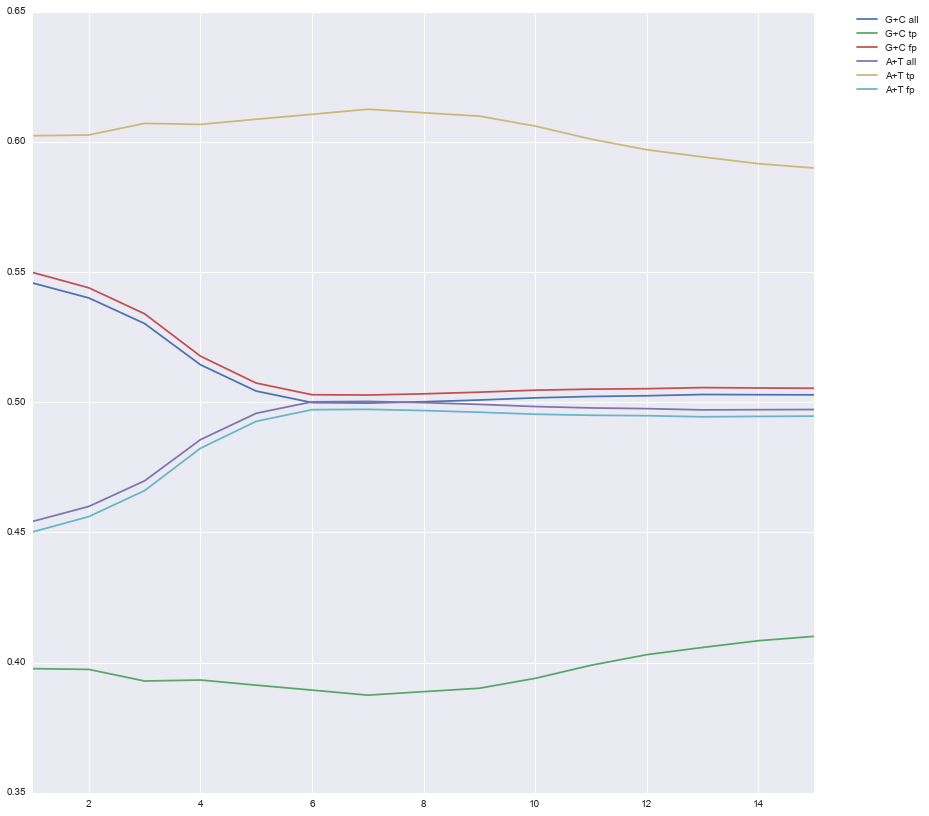

In [117]:
plt.figure(figsize=(14,14))
freq_right['G+C'].plot(label='G+C all')
freq_right_tp['G+C'].plot(label='G+C tp')
freq_right_fp['G+C'].plot(label='G+C fp')
freq_right['A+T'].plot(label='A+T all')
freq_right_tp['A+T'].plot(label='A+T tp')
freq_right_fp['A+T'].plot(label='A+T fp')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### 4. PCA from tp and fp

In [23]:
data_X,data_y = feature_matrix(reference,tp_vcf,fp_vcf)

In [96]:
data = data_X.T
for col in range(12):
    data[col] = (data[col] - data[col].mean())/data[col].std(ddof=0)
print data
pca = PCA(n_components=2)
#X_reduced = pca.fit_transform(data_X.T.as_matrix())
X_reduced = pca.fit_transform(data.as_matrix())
X_red = pd.DataFrame()
X_red['1 eigen'] = X_reduced[:,0]
X_red['2 eigen'] = X_reduced[:,1]
X_red['truth'] = ['true positive' if int(x)==1 else 'false positive' for x in data_y]

              0         1         2         3         4         5         6   \
0       2.059871 -0.543843 -1.134889 -1.106391  1.106391 -0.788330  0.788330   
1       0.010026  0.547292 -1.134889 -1.106391  1.106391 -0.255183  0.255183   
2       1.783667 -0.543843 -0.697627 -1.106391  1.106391 -0.788330  0.788330   
3       1.204311 -0.543843 -1.134889 -1.106391  1.106391 -0.788330  0.788330   
4      -2.711681 -0.543843 -1.134889 -0.327266  0.327266 -0.788330  0.788330   
5      -0.420206 -0.543843 -0.260366 -0.327266  0.327266 -1.321477  1.321477   
6       0.020635 -0.543843 -1.134889 -0.327266  0.327266 -0.788330  0.788330   
7       0.116679 -0.543843 -1.134889 -0.327266  0.327266 -0.255183  0.255183   
8       2.118750 -0.543843 -1.134889 -1.106391  1.106391 -1.321477  1.321477   
9       0.670488 -0.543843 -0.260366 -0.327266  0.327266 -0.788330  0.788330   
10     -2.889321  0.547292 -0.260366 -1.106391  1.106391 -0.255183  0.255183   
11     -0.545596 -0.543843 -1.134889 -1.

In [98]:
print pca.components_

[[-0.04811613 -0.02904697 -0.28766905 -0.46864594  0.46864594 -0.48507109
   0.48507109 -0.02958831 -0.01082362 -0.00288244 -0.00611104 -0.05659855]
 [-0.10028581 -0.07178103  0.02609052 -0.09254721  0.09254721  0.09914501
  -0.09914501 -0.6861462   0.68605441 -0.04204751 -0.03133019  0.05570675]]


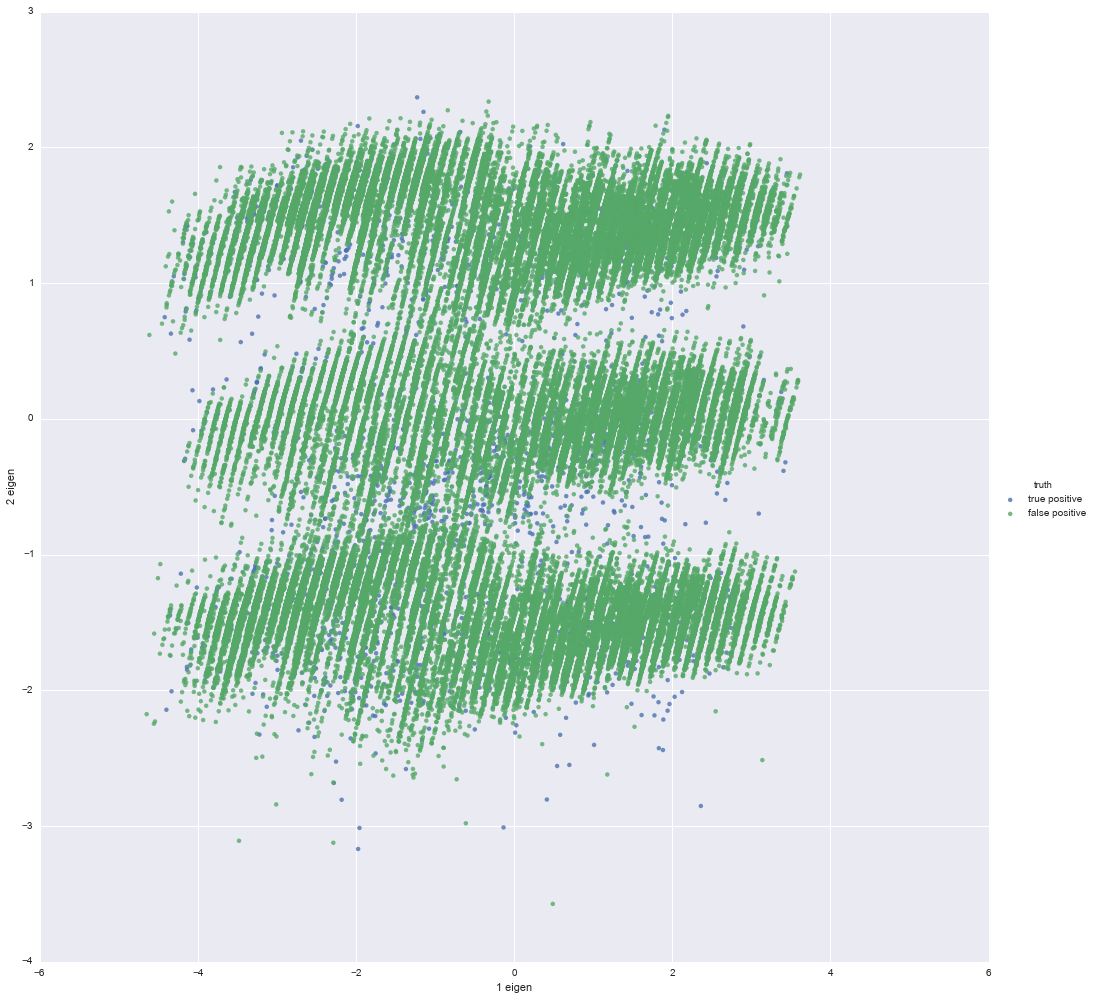

In [99]:
%matplotlib inline
sns.lmplot(x='1 eigen',y='2 eigen',hue='truth',data=X_red,size=14,fit_reg=False)


### 5. Count homopolymers with indels

In [32]:
df_with_indels = count_homopolymers_with_indels(reference,our_vcf)
df_tp_with_indels = count_homopolymers_with_indels(reference,tp_vcf)
df_fp_with_indels = count_homopolymers_with_indels(reference,fp_vcf)

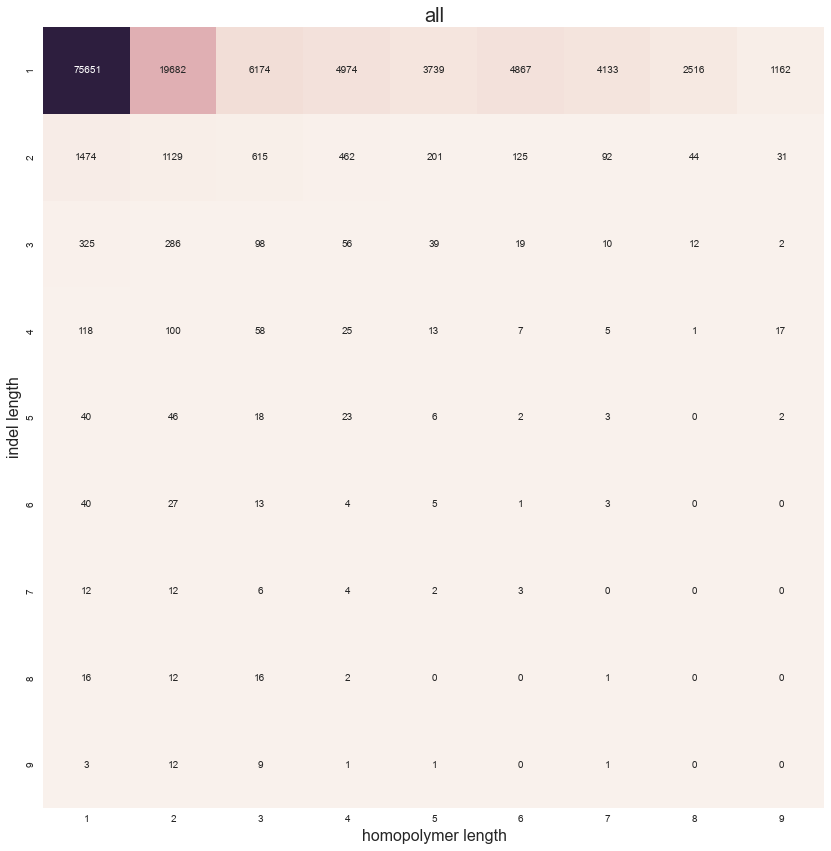

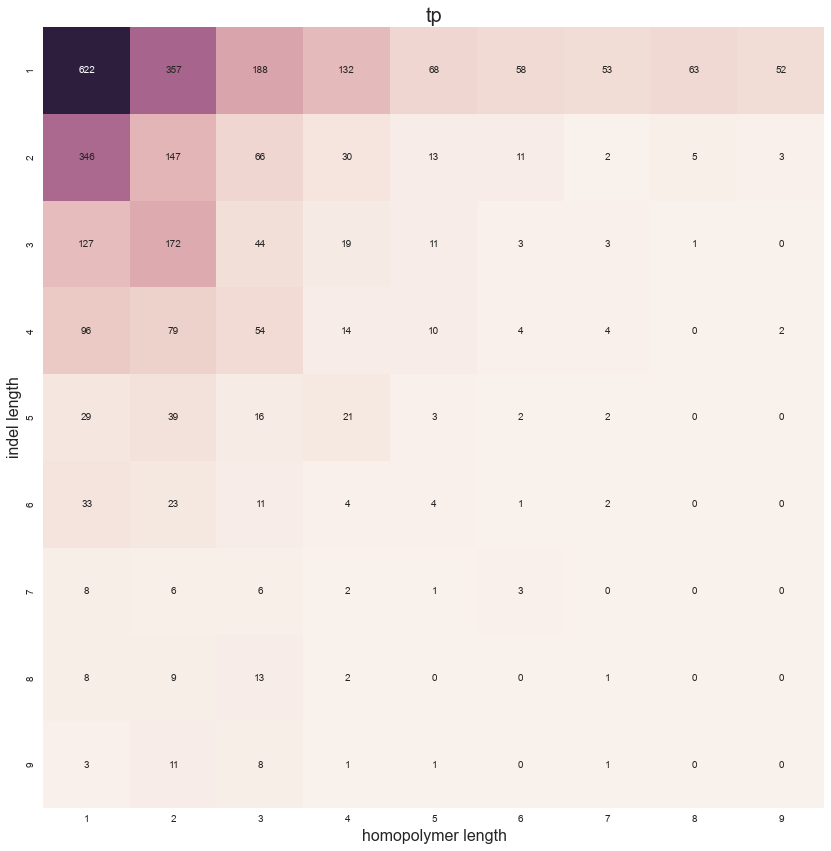

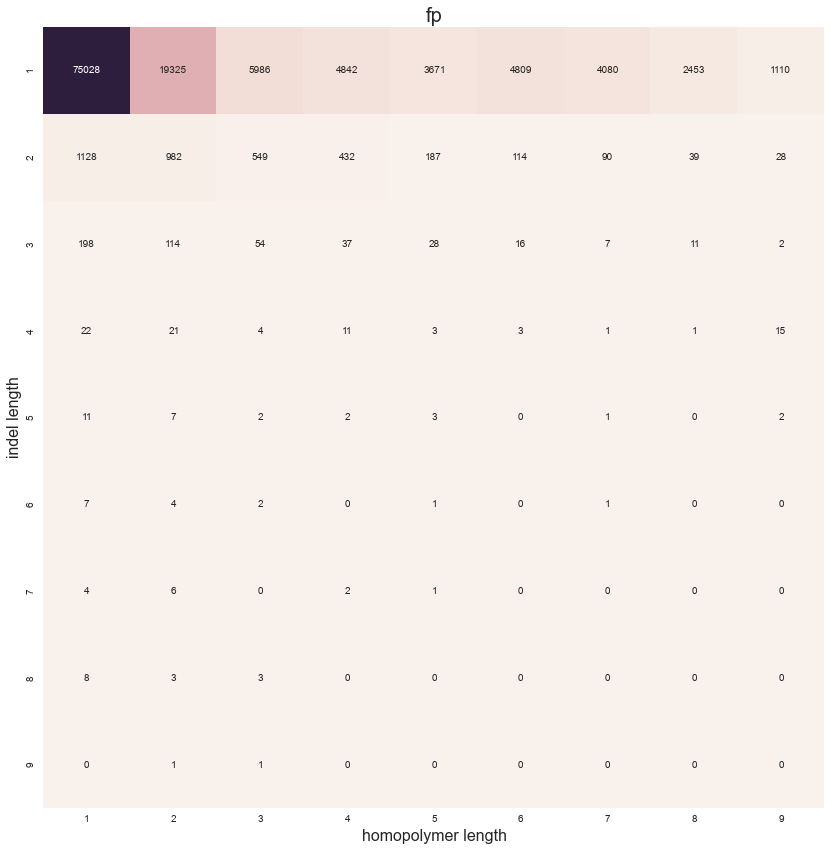

In [31]:
for df,name in [[df_with_indels,'all'],[df_tp_with_indels,'tp'],[df_fp_with_indels,'fp']]:
    fig = plt.figure(figsize=(14, 14), dpi=500)
    hmap = sns.heatmap(df.as_matrix()[1:10,1:10],cbar = False,annot = True, fmt = 'd',xticklabels = np.arange(9)+1,yticklabels = np.arange(9)+1)
    plt.xlabel('homopolymer length',fontsize=16)
    plt.ylabel('indel length',fontsize=16)
    plt.title(name,fontsize = 20)

### 6. Analysis of location of indels in reads

In [110]:
positions_data_tp = indel_positions_in_reads(reference,our_bam,tp_vcf)
positions_data_fp = indel_positions_in_reads(reference,our_bam,fp_vcf)
%store positions_data_tp
%store positions_data_fp

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
Stored 'position

In [7]:
%store -r
positions_data_tp_percentage = np.asarray([float(y[0])/y[1] for x in positions_data_tp for y in x])
positions_data_fp_percentage = np.asarray([float(y[0])/y[1] for x in positions_data_fp for y in x])

0.0042194092827 0.507643919076 0.996031746032


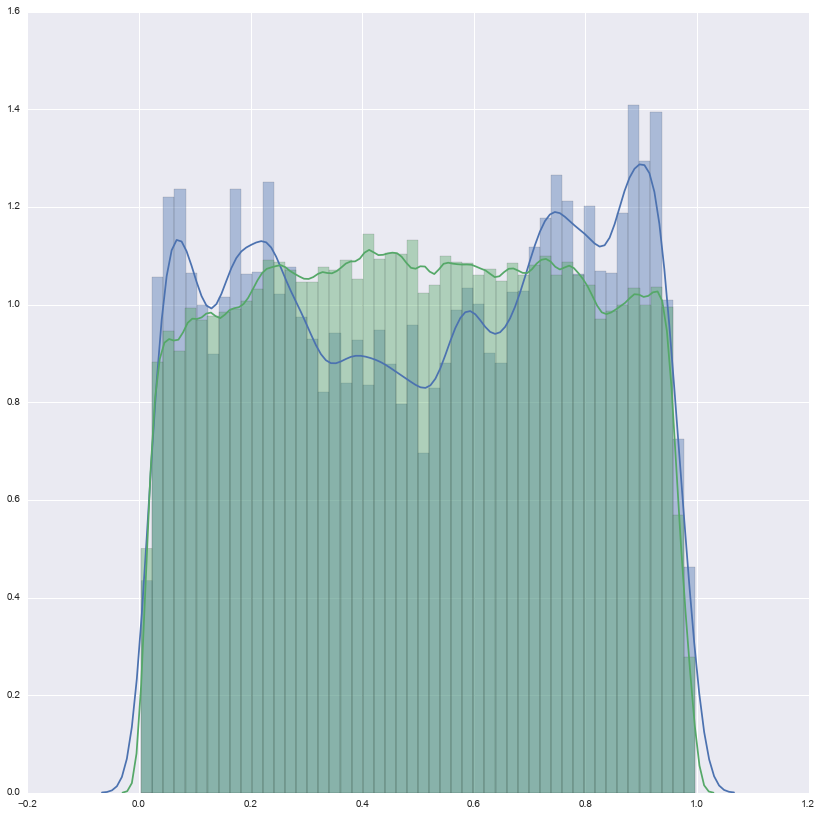

In [32]:
%matplotlib inline 
plt.figure(figsize=(14,14))
sns.set(color_codes=True)
sns.distplot(positions_data_tp_percentage,hist=True,label='tp')
sns.distplot(positions_data_fp_percentage,hist=True,label='fp')

### 7. Analysis of reads-proofs of indels

In [30]:
data_proofs = indel_proofs(reference,our_bam,our_vcf)
%store data_proofs
data_proofs_tp = indel_proofs(reference,our_bam,tp_vcf)
%store data_proofs_tp
data_proofs_fp = indel_proofs(reference,our_bam,fp_vcf)
%store data_proofs_fp

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
Stored 'data_proofs' (list)
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0

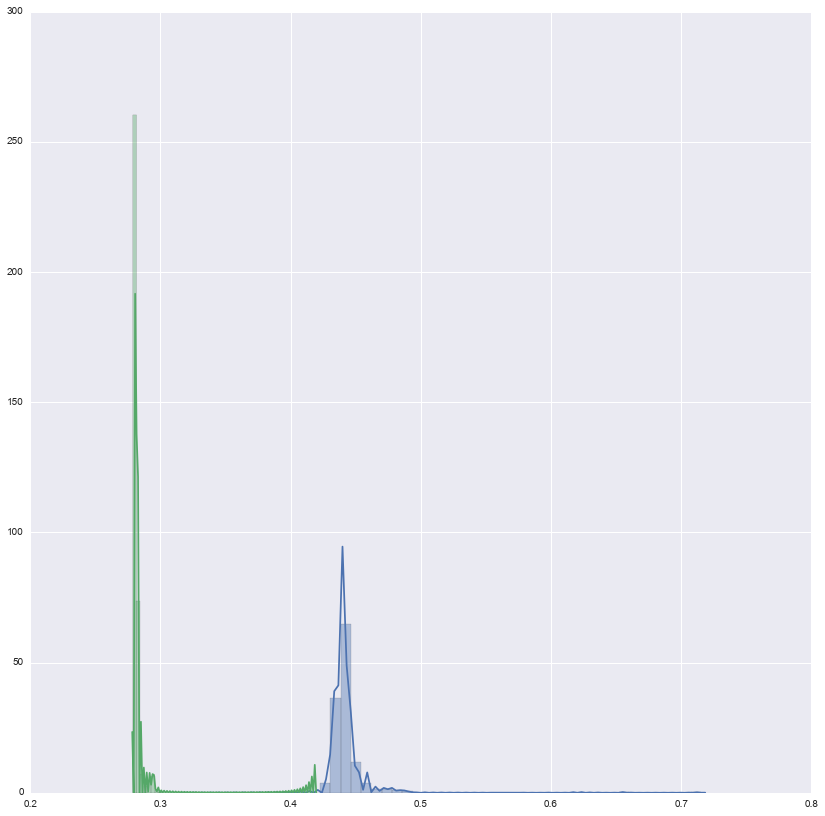

In [31]:
%matplotlib inline 
plt.figure(figsize=(14,14))
sns.set(color_codes=True)
sns.distplot(data_proofs_tp,hist=True,col,label='tp')
sns.distplot(data_proofs_fp,hist=True,label='fp')

In [85]:
samfile = pysam.AlignmentFile("/home/alexgri/indels/GoldenStandard_OurAlgorithms/gcat_set_059-ready.bam", "rb")
#for read in samfile.fetch('1', 1019890, 1019891):
#     print read
position = 874549

for pileupcolumn in samfile.pileup('1', pos, pos+1):
    print ("\ncoverage at base %s = %s" %(pileupcolumn.pos, pileupcolumn.n))
    for pileupread in pileupcolumn.pileups:
        #print pileupread.alignment.seq
        if not pileupread.is_del and not pileupread.is_refskip and (pos-pileupread.alignment.pos>=0) and (pos-pileupread.alignment.pos<len(pileupread.alignment.seq)):
            print ('\tbase in read %s = %s' %(pileupread.alignment.query_name,pileupread.alignment.query_sequence[pos - pileupread.alignment.pos]))
samfile.close()


coverage at base 874449 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874450 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874451 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874452 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874453 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874454 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874455 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874456 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874457 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874458 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874459 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874460 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874461 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874462 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874463 = 1
	base in read UJS07:01206:05860 = G

coverage at base 874464 